# Predict tags on StackOverflow with linear models
Multilabel classification approach.


In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import nltk
from sklearn.model_selection import train_test_split

In [2]:
db_path = "D:/C-Drive Project's Datasets/stack-overflow-tag-prediction/train.csv"

In [3]:
data = pd.read_csv(db_path)

In [4]:
data.head()

,title,tags
0,How to draw a stacked dotplot in R?,['r']
1,mysql select all records where a datetime fiel...,"['php', 'mysql']"
2,How to terminate windows phone 8.1 app,['c#']
3,get current time in a specific country via jquery,"['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,['java']


Since tags is not in alike for and we wish to convert strings to single list, literal_eval is used.


In [5]:
data['tags'] = data['tags'].apply(literal_eval)

In [6]:
data.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [7]:
data.shape

(100000, 2)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['title'], data['tags'], test_size=0.2, random_state = 20)

### TEXT PREPROCESSING
* lowercase every word
* remove stopwords (nltk list)
* remove junk characters via re lib

In [9]:
import re
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = stopwords.words('english')

In [10]:
def text_prepare(text):
    # lowercase text
    text = text.lower() 
    
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)
    
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    
    text = " " + text + " "
    
#     delete stopwors from text
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ") 
     
#   Removing white spaces from he sides of the text
    text = re.sub('[ ][ ]+', " ", text)
    if text[0] == ' ':
        text = text[1:]
    if text[-1] == ' ':
        text = text[:-1]

    return text

In [11]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

In [12]:
X_train[:3]

['cocoa app system restart',
 'imacro use specifc macro html element present attrclassimg',
 'store subprocesscall stdout variable load back json']

#### Words-Tags-Count
* Find 3  most popular tags and 3 most popular words in the train data

In [13]:
from collections import Counter
tags_counts = Counter();
for labels in y_train:
    for tag in labels:
        tags_counts[tag] += 1
        
words_counts = Counter();
for sentence in X_train:
    for word in sentence.split():
        words_counts[word] += 1;

In [14]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

In [15]:
most_common_tags

[('javascript', 15309), ('c#', 15259), ('java', 14830)]

In [16]:
most_common_words

[('using', 6636), ('php', 4478), ('java', 4369)]

### Transforming Text To A Vector
* Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors.

#### BAG OF WORDS
* Find N most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
* For each title in the corpora create a zero vector with the dimension equals to N.
* For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.



In [17]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:6000]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:6000]

In [18]:
most_common_tags[:10]

[('javascript', 15309),
 ('c#', 15259),
 ('java', 14830),
 ('php', 11178),
 ('python', 7114),
 ('jquery', 6017),
 ('c++', 5163),
 ('html', 3726),
 ('objective-c', 3471),
 ('asp.net', 3147)]

* Choosing value of N as 5000 =>  5000 most common words will be used.
* Since we can not work with string values, we require each word to correspond to a unique index. (WORDS_TO_INDEX & INDEX_TO_WORDS)


In [19]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {cw[0]:i for i,cw in enumerate(most_common_words[:DICT_SIZE])} 
INDEX_TO_WORDS = {WORDS_TO_INDEX[k]:k for k in WORDS_TO_INDEX}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [20]:
def my_bag_of_words(text, words_to_index, dict_size):
    # Initialize a vector of size = dict_size
    result_vector = np.zeros(dict_size)
    
    # Increase vector element's count as the word at a particular index appears
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
            
    return result_vector    

In [21]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you the aoudi ']
    answers = [[1, 1, 0, 1]]
    
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
        
    return 'Basic tests are passed.'

Applying the implemented functions on all samples.
* SciPy 2-D sparse matrix package for numeric data. 
* CSR_Matrix(x) Compressed Sparse Row matrix with a dense matrix or rank-2 ndarray D - transform the data to sparse representation (sklearn can only work with csr only)

From each row of X_train we will recieve a collection of the most common words that occured in the sentence. Each of the row with its single word will get a frequency vector from my_bag_of_words function. For each of this sparse matrix we convert it into dense matrix and verticaly stack them together

In [22]:
from scipy import sparse

In [23]:
X_train_mybag = sparse.vstack([sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sparse.vstack([sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (80000, 5000)
X_test shape  (20000, 5000)


In [24]:
print(most_common_words[:10])
for w in X_train[10].split():
    print(w)
    print(w in WORDS_TO_INDEX)

[('using', 6636), ('php', 4478), ('java', 4369), ('file', 4064), ('javascript', 3814), ('error', 3532), ('get', 3465), ('c#', 3340), ('python', 3212), ('string', 2920)]
subview
True
removed
True
remove
True
superview
True


 For the 11th row in X_train_mybag find how many non-zero elements it has. In this task the answer (variable non_zero_elements_count) should be a number, e.g. 20.

In [25]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

In [26]:
non_zero_elements_count

4

### TF-IDF
The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space.



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
# use '(\S+)' regexp as a token_pattern in the constructor of the vectorizer.

In [28]:
def tfidf_features(X_train, X_test):
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)',min_df=5, max_df=0.9, ngram_range=(1,2)) 
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train,  X_test, tfidf_vectorizer.vocabulary_

In [29]:
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [30]:
print('c++' in tfidf_vocab)
print('c#' in tfidf_vocab)
print('java' in tfidf_vocab)

True
True
True


### MultiLabel classifier
As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use MultiLabelBinarizer from sklearn.

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

In [32]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))

In [33]:
y_train = mlb.fit_transform(y_train)

In [34]:
y_test = mlb.fit_transform(y_test)

Use One-vs-Rest approach, which is implemented in OneVsRestClassifier class. 

In this approach k classifiers (= number of tags) are trained. As a basic classifier, use LogisticRegression. It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [36]:
def train_classifier(X_train, y_train, C=1.0, penalty='l2'):
    
    lr = LogisticRegression(C=C, penalty=penalty)
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

In [37]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [38]:
predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [39]:
y_pred_inversed = mlb.inverse_transform(predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)

for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_pred_inversed[i])
    ))

Title:	import sas data file python data frame
True labels:	pandas,python
Predicted labels:	python


Title:	maximum possible length fileversioninfofileversion string windows
True labels:	c#,file
Predicted labels:	c#


Title:	undo loggingdisable command logging module python
True labels:	python
Predicted labels:	python





Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure.



#### EVALUATION
To evaluate the results we will use several classification metrics:

* Accuracy
* F1-score
* Area under ROC-curve
* Area under precision-recall curve

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [54]:
def print_evaluation_scores(y_val, predicted):
    # print(len(y_val), len(y_val))
    accuracy = accuracy_score(y_val, predicted)
    print(accuracy,
          f1_score(y_val, predicted, average='macro'),
          f1_score(y_val, predicted, average='micro'),
          f1_score(y_val, predicted, average='weighted'),
          average_precision_score(y_val, predicted, average='macro'),
          average_precision_score(y_val, predicted, average='micro'),
          average_precision_score(y_val, predicted, average='weighted')
         )

In [53]:
print('Bag-of-words')
print_evaluation_scores(y_test, predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_test, predicted_labels_tfidf)

Bag-of-words
0.36135 0.5080482886332666 0.6707928549044188 0.6489009866962909 0.34833945219462187 0.48073633526774817 0.5113722847236191
Tfidf


C:\Users\bpakh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.333 0.44104601494399626 0.6348345450613073 0.6070826051606691 0.2995459576653857 0.4502673578391516 0.47903609430238375


Plot some generalization of the ROC curve for the case of multi-label classification. Provided function roc_auc can make it for you. The input parameters of this function are:

* true labels
* decision functions scores
* number of classes

In [43]:
from metrics import roc_auc
%matplotlib inline

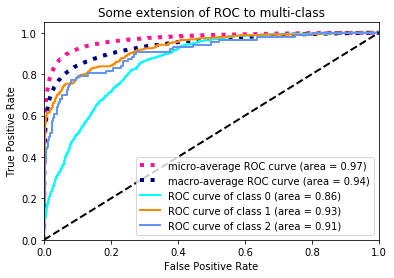

In [45]:
n_classes = len(tags_counts)
roc_auc(y_test, predicted_scores_mybag, n_classes)

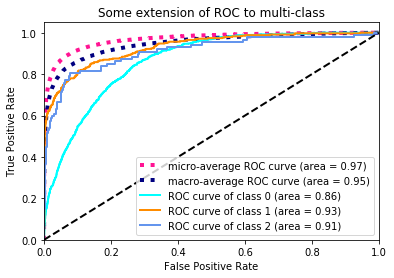

In [47]:
n_classes = len(tags_counts)
roc_auc(y_test, predicted_scores_tfidf, n_classes)

### MULTILABEL CLASSIFICATION
* compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
* for the chosen one, try L1 and L2-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

In [55]:
def evaluate(C, penalty):
    classifier_mybag = train_classifier(X_train_mybag, y_train, C, penalty)
    classifier_tfidf = train_classifier(X_train_tfidf, y_train, C, penalty)
    predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
    predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

    predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
    predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)
    print('Bag-of-words')
    print_evaluation_scores(y_test, predicted_labels_mybag)
    print('Tfidf')
    print_evaluation_scores(y_test, predicted_labels_tfidf)

In [56]:
evaluate(C=10.0, penalty='l2')

Bag-of-words
0.3478 0.5116949248913185 0.6663198418478827 0.6510912437508442 0.33179383662750067 0.46292777398974033 0.49907627034228264
Tfidf
0.3651 0.5104793468497327 0.674502712477396 0.6539916386249882 0.3440384598930888 0.48030249784891554 0.510054932963895


In [58]:
print(classifier_tfidf.coef_.shape)
print(mlb.classes)
print(mlb.classes.index('java'))
coef=classifier_tfidf.coef_[mlb.classes.index('java')]
cd = {i:coef[i] for i in range(len(coef))}
scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
print(scd[:3],scd[-3:])

(100, 14850)
['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache', 'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class', 'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date', 'datetime', 'django', 'dom', 'eclipse', 'entity-framework', 'excel', 'facebook', 'file', 'forms', 'function', 'generics', 'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel', 'linq', 'linux', 'list', 'loops', 'maven', 'mongodb', 'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c', 'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php', 'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r', 'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3', 'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring', 'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing', 'twitter-bootstrap', 'uitableview', 'unit-testing', 'validation', 'vb.net', 'visual-studio', 'visual-studio-20

In [59]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
 
    print('Tag:\t{}'.format(tag))
    
    idx = tags_classes.index(tag)
    coef=classifier_tfidf.coef_[idx]
    cd = {i:coef[i] for i in range(len(coef))}
    scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
   
    top_positive_words = [index_to_words[k[0]] for k in scd[:5]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[k[0]] for k in scd[-5:]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [60]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, pointer, gcc
Top negative words:	c#, javascript, python, java, php

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	c#, javascript, python, php, java

Tag:	linux
Top positive words:	linux, ubuntu, c, signal, gcc
Top negative words:	data, jquery, array, c#, javascript

